<a href="https://colab.research.google.com/github/ferdinand1810/Metodos_Numericos_Aplicados_Ingenieria_UTEC/blob/main/OpenChannelFlow_VFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Simulación de Aguas Poco Profundas Usando el Metodo de Volumenes Finitos (FVM)
# En un Canal Rectangular a Flujo a Superficie Libre.

!pip install pyvista
!pip install vtk
import numpy as np
import pyvista as pv
import os

# Archivos de Entrada y Salida I/O
simulation_name = "swe_FVM"
result_path = f"./result/{simulation_name}/"
os.makedirs(result_path, exist_ok=True)

# Dominio Computacional
xlen, ylen, divs = 2, 7, 60
dx, dy = xlen / divs, ylen / divs
x = np.arange(-1 - dx, 1 + dx, dx)
y = np.arange(-1 - dy, 1 + dy, dy)
xx, yy = np.meshgrid(x, y)

print(f"Domain X: {np.min(xx)} to {np.max(xx)}")
print(f"Domain Y: {np.min(yy)} to {np.max(yy)}")

# Parametros del Modelo
g = 9.8
cfl = 0.5

# Función de valores eta iniciales
def eta_initial(y, x):
    Amp = 8.0
    x0, y0 = -0.1, -0.9
    sigma = 0.3
    return Amp * np.exp(-((0.02 * (x - x0)**2 + (y - y0)**2) / sigma**2))

# Profundidad de la base + amplitud gaussiana
eta = np.ones_like(xx)
eta += eta_initial(yy, xx)

# Inicializar la variable de solución como [tamaño de malla x 3]
Solution = np.zeros([xx.shape[0], xx.shape[1], 3])
Solution[:, :, 0] = eta  # eta
u = np.zeros_like(xx)
v = np.zeros_like(xx)

# Cambio de índice para BC periódicos
p_p1_x = np.roll(np.arange(len(x)), 1)
p_p1_y = np.roll(np.arange(len(y)), 1)
p_m1_x = np.roll(np.arange(len(x)), -1)
p_m1_y = np.roll(np.arange(len(y)), -1)

# Parámetros de tiempo
t_curr, dt, t_stop = 0.0, 0.0, 2.0
etas_list, times = [], [t_curr]
Solution_old = Solution.copy()
counter = 0

# Marcha en el tiempo
while t_curr < t_stop:
   # Actualizar la altura del agua
    hsol = Solution[:, :, 0]

    # Actualizar velocidades
    u = Solution[:, :, 1] / Solution[:, :, 0]
    v = Solution[:, :, 2] / Solution[:, :, 0]
    velocity_vector = np.stack([u, v, np.zeros_like(u)], axis=-1).reshape(-1, 3, order="F")

    # Create surface grid (for glyphs/contours)
    grid = pv.StructuredGrid(xx * xlen, yy * ylen, hsol)
    grid.point_data["height"] = hsol.flatten(order="F")
    grid.point_data["velocity"] = velocity_vector

    # Extrude 3D volume for visualization
    top = grid.points.copy()
    bottom = grid.points.copy()
    bottom[:, -1] = -5.0
    vol = pv.StructuredGrid()
    vol.points = np.vstack([top, bottom])
    vol.dimensions = [*grid.dimensions[0:2], 2]

    # Fill volume data
    zlevels = vol.points[:, 2]
    zlevels[zlevels < np.min(hsol)] = -0.5
    vol.point_data["height"] = zlevels
    vol.point_data["velocity"] = np.tile(velocity_vector, (2, 1))

    # Save full field data
    vol.save(f"{result_path}fields_{counter:04d}.vtk")

    u_old, v_old = u.copy(), v.copy()
    t_curr += dt
    times.append(t_curr)

    alpha_u = 0.5 * np.abs(u_old + u_old[:, p_m1_x]) + np.sqrt(g * 0.5 * (Solution_old[:, :, 0] + Solution_old[:, p_m1_x, 0]))
    alpha_v = 0.5 * np.abs(v_old + v_old[p_m1_y, :]) + np.sqrt(g * 0.5 * (Solution_old[:, :, 0] + Solution_old[p_m1_y, :, 0]))

    alpha_max = np.max([np.max(alpha_u), np.max(alpha_v)])
    dt = min(cfl * dx / alpha_max, cfl * dy / alpha_max)

    huv = Solution_old[:, :, 1] * Solution_old[:, :, 2] / Solution_old[:, :, 0]
    gh_sqr = 0.5 * g * Solution_old[:, :, 0]**2

    LFFlux_u = np.stack([
        Solution_old[:, :, 1],
        Solution_old[:, :, 1]**2 / Solution_old[:, :, 0] + gh_sqr,
        huv
    ], axis=2)

    LFFlux_v = np.stack([
        Solution_old[:, :, 2],
        huv,
        Solution_old[:, :, 2]**2 / Solution_old[:, :, 0] + gh_sqr
    ], axis=2)

    flux_x = np.zeros_like(LFFlux_u)
    flux_y = np.zeros_like(LFFlux_v)

    for ii in range(3):
        temp_LFFluxu = LFFlux_u[:, p_m1_x, ii]
        temp_Uold = Solution_old[:, p_m1_x, ii] - Solution_old[:, :, ii]
        flux_x[:, :, ii] = 0.5 * (LFFlux_u[:, :, ii] + temp_LFFluxu) - 0.5 * temp_Uold * alpha_u

        temp_LFFluxv = LFFlux_v[p_m1_y, :, ii]
        temp_Uold = Solution_old[p_m1_y, :, ii] - Solution_old[:, :, ii]
        flux_y[:, :, ii] = 0.5 * (LFFlux_v[:, :, ii] + temp_LFFluxv) - 0.5 * temp_Uold * alpha_v

    Solution = Solution_old - (dt / dx) * (flux_x - flux_x[:, p_p1_x, :]) - (dt / dy) * (flux_y - flux_y[p_p1_y, :, :])

    # Condiciones de Borde
    Solution[:, -1, 0] = Solution[:, -2, 0]
    Solution[:, 0, 0] = Solution[:, 1, 0]
    Solution[-1, :, 0] = Solution[-2, :, 0]
    Solution[0, :, 0] = Solution[1, :, 0]

    Solution[:, -1, 1] = -Solution[:, -2, 1]
    Solution[:, 0, 1] = -Solution[:, 1, 1]
    Solution[-1, :, 1] = Solution[-2, :, 1]
    Solution[0, :, 1] = Solution[1, :, 1]

    Solution[:, -1, 2] = Solution[:, -2, 2]
    Solution[:, 0, 2] = Solution[:, 1, 2]
    Solution[-1, :, 2] = -Solution[-2, :, 2]
    Solution[0, :, 2] = -Solution[1, :, 2]

    u = Solution[:, :, 1] / Solution[:, :, 0]
    v = Solution[:, :, 2] / Solution[:, :, 0]

    # Create velocity vector for each point (flattened in Fortran order)
    velocity_vector = np.stack([u, v, np.zeros_like(u)], axis=-1).reshape(-1, 3, order="F")

    # Assign velocity field to grid
    grid.point_data["velocity"] = velocity_vector

    # Add the same velocity data to the extruded volume
    vol.point_data["velocity"] = np.tile(velocity_vector, (2, 1))  # top and bottom layers

    print(f"Done timestep {t_curr:.04f}")
    etas_list.append(Solution[:, :, 0])
    Solution_old = Solution.copy()
    counter += 1

print("Done!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.8 MB/s eta 0:00:00
Domain X: -1.0333333333333334 to 1.0333333333333397
Domain Y: -1.1166666666666667 to 1.1000000000000005
Done timestep 0.0000
Done timestep 0.0018
Done timestep 0.0036
Done timestep 0.0054
Done timestep 0.0072
Done timestep 0.0090
Done timestep 0.0108
Done timestep 0.0125
Done timestep 0.0143
Done timestep 0.0160
Done timestep 0.0177
Done timestep 0.0194
Done timestep 0.0211
Done timestep 0.0228
Done timestep 0.0245
Done timestep 0.0261
Done timestep 0.0278
Done timestep 0.0294
Done timestep 0.0311
Done timestep 0.0327
Done timestep 0.0343
Done timestep 0.0359
Done timestep 0.0375
Done timestep 0.0391
Done timestep 0.0407
Done timestep 0.0423
Done timestep 0.0439
Done timestep 0.0455
Done timestep 0.0470
Done timestep 0.0486
Done timestep 0.0502
Done timestep 0.0517
Done timestep 0.0533
Done timestep 0.0549
Done timestep 0.0564
Done

In [8]:
    # Cálculo y graficado del error (norma L2 entre eta actual y anterior)
    error_eta = np.linalg.norm(Solution[:, :, 0] - Solution_old[:, :, 0]) / np.linalg.norm(Solution_old[:, :, 0])
    print(f"Error relativo en eta: {error_eta:.2e}")

Error relativo en eta: 0.00e+00


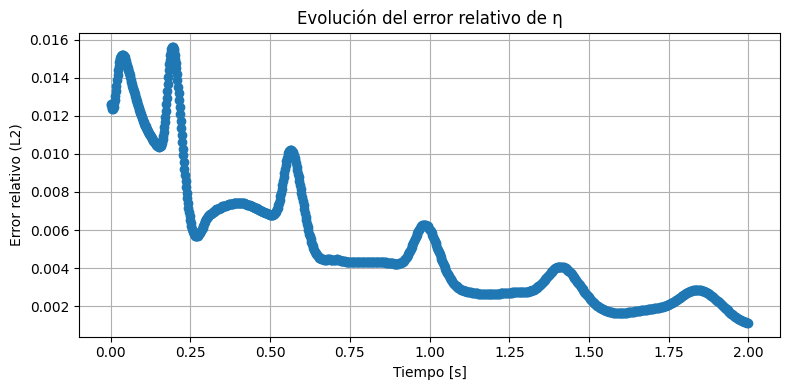

In [9]:
# Graficar evolución del error
plt.figure(figsize=(8, 4))
errores = [np.linalg.norm(etas_list[i] - etas_list[i - 1]) / np.linalg.norm(etas_list[i - 1]) for i in range(1, len(etas_list))]
plt.plot(times[1:len(etas_list)], errores, marker='o')
plt.xlabel("Tiempo [s]")
plt.ylabel("Error relativo (L2)")
plt.title("Evolución del error relativo de η")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{result_path}error_evolucion.png", dpi=300)
plt.show()
